In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


Mounted at /content/drive
/content/drive/MyDrive/dl-project


In [2]:
# pip install --upgrade pip

In [3]:
import os
import yaml

with open("environment.yml") as file_handle:
     environment_data = yaml.safe_load(file_handle)

for dependency in environment_data["dependencies"]:
    if isinstance(dependency, dict):
        for lib in dependency['pip']:
            os.system(f"pip install {lib}")

  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)


ERROR: Operation cancelled by user


  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.


  Using cached torch-2.0.0-cp38-cp38-manylinux1_x86_64.whl (619.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 2.0.0 which is incompatible.


In [4]:
!pip install transformers datasets matplotlib
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Must sign up for the competition and verify your account with a text message before downloading the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib

import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.datasets.TextShopeeDataset import TextShopeeDataset
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.BERTPreTrainedEmbeddingsShopeeNet import BERTPreTrainedEmbeddingsShopeeNet
from modules.models.ImageShopeeNet import ImageShopeeNet
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
import faiss
import os

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
DATA_FOLDER = './shopee-product-matching/'

IS_TEST = False

def get_dataset(root=DATA_FOLDER, is_test=False):
    name = "test.csv" if is_test else "train.csv"
    df = pd.read_csv(DATA_FOLDER + name)
    images_folder = "test_images/" if is_test else "train_images/"
    df['image'] = DATA_FOLDER + images_folder + df['image']
    return df

def add_target(df):
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    target = df['label_group'].map(grouped)
    new_df = df.copy()
    new_df['target'] = target
    return new_df

df = get_dataset(is_test=IS_TEST)
df = df.head(2500)
train = add_target(df)

In [31]:
# Prepare DataLoaders
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_dataset = TextShopeeDataset(train['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    
    # This probably could be optimized if we don't want to instantiate a new tokenizer each iteration.
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
text_loader = torch.utils.data.DataLoader(
    text_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

trans = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) 
train_dataset = ImageShopeeDataset(
    train['image'].values,
    trans)

image_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

/usr/local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_pretrain_model = BERTPreTrainedEmbeddingsShopeeNet()
bert_pretrain_model.to(DEVICE)
text_producer = EmbeddingsProducer(bert_pretrain_model, DEVICE)

resnet_pretrain_model = ImageShopeeNet()
resnet_pretrain_model.to(DEVICE)
image_producer = EmbeddingsProducer(resnet_pretrain_model, DEVICE)

text_embeddings = text_producer.get_embeddings(text_loader, normalize=True)
image_embeddings = image_producer.get_embeddings(image_loader, normalize=True)
full_embeddings = np.concatenate((text_embeddings, image_embeddings), axis=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 40/40 [03:09<00:00,  4.74s/it]


In [33]:
# Using this repository https://github.com/sonisanskar/Neighborhood-Blending
# !pip install NeighborBlend

In [34]:
# !pip uninstall scikit-learn
!pip install scikit-learn

In [36]:
import sklearn.preprocessing 

def neighborhood_search(emb,thresh,k_neighbors):
    index = faiss.IndexFlatIP(emb.shape[1])
    faiss.normalize_L2(emb)
    index.add(emb)
    
    sim, I = index.search(emb, k_neighbors)
    
    pred_index=[]
    pred_sim=[]
    for i in range(emb.shape[0]):
        cut_index=0
        for j in sim[i]:
            if(j>thresh):
                cut_index+=1
            else:
                break
        
        pred_index .append( I[i][:(cut_index)])
        pred_sim .append (sim[i][:(cut_index)])
   
        
    return pred_index,pred_sim

def blend_neighborhood(emb, match_index_lst, similarities_lst):
    new_emb = emb.copy()
    for i in range(emb.shape[0]):
        cur_emb = emb[match_index_lst[i]]
        
        weights = np.expand_dims(similarities_lst[i], 1)
        
        new_emb[i] = (cur_emb * weights).sum(axis=0)
        
    new_emb = sklearn.preprocessing.normalize(new_emb, axis=1)
    
    return new_emb

def iterative_neighborhood_blending(emb, threshes,k_neighbors):
    for thresh in threshes:
        match_index_lst, similarities_lst = neighborhood_search(emb, thresh,k_neighbors)
        emb = blend_neighborhood(emb, match_index_lst, similarities_lst)
    return emb,match_index_lst,similarities_lst

In [109]:
# Final matches from the Single Embeddings 

k = 50 
single_thresh_great = 0.95
# given an embedding, find the 50 similar ones
matches_text_final, sim_text_final = neighborhood_search(text_embeddings,  single_thresh_great, k)
matches_image_final, sim_image_final = neighborhood_search(image_embeddings,  single_thresh_great, k)
matches_comb_final, sim_comb_final = neighborhood_search(full_embeddings,  single_thresh_great, k)

In [110]:
# Matches that will go into the NB pipeline

k = 50 
single_thresh_ok = 0.5
# given an embedding, find the 50 similar ones
matches_text_nb, sim_text_nb = neighborhood_search(text_embeddings,  single_thresh_ok, k)
matches_image_nb, sim_image_nb = neighborhood_search(image_embeddings,  single_thresh_ok, k)
matches_comb_nb, sim_comb_nb = neighborhood_search(full_embeddings,  single_thresh_ok, k)

In [111]:
# Join the matches and similarities
matches_nb = []
matches_nb.extend(matches_image_nb)
matches_nb.extend(matches_text_nb)
matches_nb.extend(matches_comb_nb)

sim_nb = []
sim_nb.extend(sim_image_nb)
sim_nb.extend(sim_text_nb)
sim_nb.extend(sim_comb_nb)

In [112]:
# NB Stage 1
thresh_stage_1 = 0.5
# TODO: Not sure about which embeddings to use
emb_nb_stage_1 = blend_neighborhood(full_embeddings, matches_nb, sim_nb)
matches_stage_1, sim_stage_1 = neighborhood_search(emb_nb_stage_1, thresh_stage_1, k)

In [113]:
# NB Stage 2
thresh_stage_2 = 0.7
# TODO: Not sure about which embeddings to use
emb_nb_stage_2 = blend_neighborhood(emb_nb_stage_1, matches_stage_1, sim_stage_1)
matches_stage_2, sim_stage_2 = neighborhood_search(emb_nb_stage_2, thresh_stage_2, k)

In [114]:
matches_nb_final = matches_stage_2
sim_nb_final = sim_stage_2

In [115]:
# Combine all matches
matches_final = []
matches_final.extend(matches_text_final)
matches_final.extend(matches_image_final)
matches_final.extend(matches_comb_final)
matches_final.extend(matches_nb_final)

sim_final = []
sim_final.extend(sim_text_final)
sim_final.extend(sim_image_final)
sim_final.extend(sim_comb_final)
sim_final.extend(sim_nb_final)

In [116]:
class F1ScoreEvaluatorNB(F1ScoreEvaluator):
    def __init__(self, df, embeddings, matches, similarities, k=100):
        self.k = k
        self.df = df
        self.embeddings = embeddings
        self.similarities = similarities
        self.indexes = matches

In [119]:
# please ensure that text_embeddings and train dataframe have the same order and embeddings correspond to postings
f1_score_eval_text = F1ScoreEvaluator(train, text_embeddings, k=100)
thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores_text = f1_score_eval_text.get_avg_f1_scores_for_thresholds(thresholds)

f1_score_eval_img = F1ScoreEvaluator(train, image_embeddings, k=100)
thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores_img = f1_score_eval_img.get_avg_f1_scores_for_thresholds(thresholds)

f1_score_eval_full = F1ScoreEvaluator(train, full_embeddings, k=100)
thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores_full = f1_score_eval_full.get_avg_f1_scores_for_thresholds(thresholds)

100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


In [120]:
f1_score_eval_nb = F1ScoreEvaluatorNB(train, emb_nb_stage_2, matches_final, sim_final)
thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores_nb = f1_score_eval_nb.get_avg_f1_scores_for_thresholds(thresholds)

100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


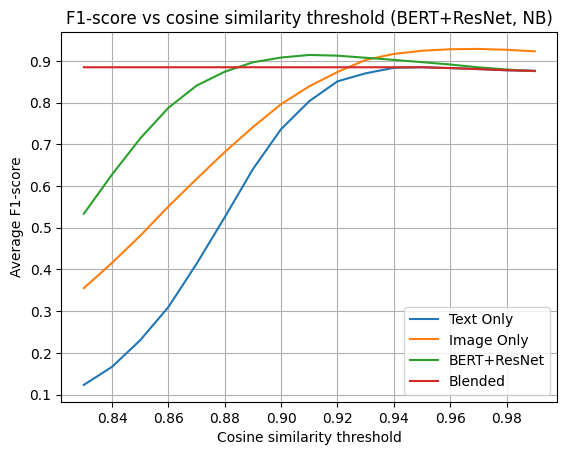

In [121]:
filename = f'nb_combined_thresholds_k{k_neighbors}.png'
base_path = '/root/DL_Group_Project/dl-ecommerce-duplicates/tempcharts/'
full_path = base_path + filename

visualizer = CommonVisualizer()
visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_text, 'Text Only', full_path, label='Text Only')
max_f1_text = max(f1_avg_scores_text)
max_threshold_text = thresholds[np.argmax(f1_avg_scores_text)]

visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_img, 'Image Only', full_path, label='Image Only')
max_f1_img = max(f1_avg_scores_img)
max_threshold_img = thresholds[np.argmax(f1_avg_scores_img)]

visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_full, 'Image Only', full_path, label='BERT+ResNet')
max_f1_full = max(f1_avg_scores_full)
max_threshold_full = thresholds[np.argmax(f1_avg_scores_full)]

visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_nb, 'BERT+ResNet, NB', full_path, label='Blended')
max_f1_nb = max(f1_avg_scores_nb)
max_threshold_nb = thresholds[np.argmax(f1_avg_scores_nb)]

In [122]:
print(f"TEXT: Max f1-score: {max_f1_text}, threshold: {max_threshold_text}")
print(f"IMG: Max f1-score: {max_f1_img}, threshold: {max_threshold_img}") 
print(f"FULL: Max f1-score: {max_f1_full}, threshold: {max_threshold_full}") 
print(f"NB: Max f1-score: {max_f1_nb}, threshold: {max_threshold_nb}") 

TEXT: Max f1-score: 0.8845716239316266, threshold: 0.9500000000000001
IMG: Max f1-score: 0.9285167291532003, threshold: 0.9700000000000001
FULL: Max f1-score: 0.9140805885856729, threshold: 0.91
NB: Max f1-score: 0.8845716239316266, threshold: 0.83
